In [ ]:
!pip install -qU "ray[data,train]"
!pip install -qU dask[complete] dask-ml scikit-learn

In [ ]:
# Data handling
import pandas as pd
import numpy as np
import uuid

# EDA and Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ML preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.svm import SVC

# Distributed processing
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler
#from dask_ml.svm import SVC

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.lightgbm import TuneReportCheckpointCallback

# Distributed training for HPCI
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.lightgbm import TuneReportCheckpointCallback
import lightgbm as lgb





EDA + Cleaning

In [ ]:
# Load data with Dask
ddf = dd.read_csv("financial_risk_assessment.csv")

# Convert to pandas for EDA
df = ddf.compute()

# Show basic info
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

# Quick overview
display(df.head())

Dataset shape: (15000, 20)

Missing values:
 Age                         0
Gender                      0
Education Level             0
Marital Status              0
Income                   2250
Credit Score             2250
Loan Amount              2250
Loan Purpose                0
Employment Status           0
Years at Current Job        0
Payment History             0
Debt-to-Income Ratio        0
Assets Value             2250
Number of Dependents     2250
City                        0
State                       0
Country                     0
Previous Defaults        2250
Marital Status Change       0
Risk Rating                 0
dtype: int64

Data types:
 Age                                int64
Gender                   string[pyarrow]
Education Level          string[pyarrow]
Marital Status           string[pyarrow]
Income                           float64
Credit Score                     float64
Loan Amount                      float64
Loan Purpose             string[pyarrow]


,Age,Gender,Education Level,Marital Status,Income,Credit Score,Loan Amount,Loan Purpose,Employment Status,Years at Current Job,Payment History,Debt-to-Income Ratio,Assets Value,Number of Dependents,City,State,Country,Previous Defaults,Marital Status Change,Risk Rating
0,49,Male,PhD,Divorced,72799.0,688.0,45713.0,Business,Unemployed,19,Poor,0.154313,120228.0,0.0,Port Elizabeth,AS,Cyprus,2.0,2,Low
1,57,Female,Bachelor's,Widowed,NaN,690.0,33835.0,Auto,Employed,6,Fair,0.148920,55849.0,0.0,North Catherine,OH,Turkmenistan,3.0,2,Medium
2,21,Non-binary,Master's,Single,55687.0,600.0,36623.0,Home,Employed,8,Fair,0.362398,180700.0,3.0,South Scott,OK,Luxembourg,3.0,2,Medium
3,59,Male,Bachelor's,Single,26508.0,622.0,26541.0,Personal,Unemployed,2,Excellent,0.454964,157319.0,3.0,Robinhaven,PR,Uganda,4.0,2,Medium
4,25,Non-binary,Bachelor's,Widowed,49427.0,766.0,36528.0,Personal,Unemployed,10,Fair,0.143242,287140.0,NaN,New Heather,IL,Namibia,3.0,1,Low


In [ ]:
# STEP 1: Drop irrelevant columns
df_clean = df.drop(columns=["City", "State", "Country"], errors='ignore')

# STEP 2: Mean imputation for numeric columns
mean_impute_cols = ['Income', 'Credit Score', 'Loan Amount', 'Assets Value']
for col in mean_impute_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

# STEP 3: KNN Imputation for selected columns
knn_impute_cols = ['Previous Defaults', 'Number of Dependents']
knn_data = df_clean[knn_impute_cols]

# Initialize KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply imputer and update DataFrame
df_clean[knn_impute_cols] = knn_imputer.fit_transform(knn_data)

# Final check
print("Any missing values left?")
print(df_clean.isnull().sum())

# Optional: Save cleaned version
df_clean.to_csv("risk_data_cleaned.csv", index=False)



Any missing values left?
Age                      0
Gender                   0
Education Level          0
Marital Status           0
Income                   0
Credit Score             0
Loan Amount              0
Loan Purpose             0
Employment Status        0
Years at Current Job     0
Payment History          0
Debt-to-Income Ratio     0
Assets Value             0
Number of Dependents     0
Previous Defaults        0
Marital Status Change    0
Risk Rating              0
dtype: int64


In [ ]:
# Standardize column name format (if you haven't yet)
df_clean.columns = df_clean.columns.str.strip().str.replace('[. ]', '_', regex=True)

# Convert selected categorical columns to pandas category type
categorical_cols = [
    'Gender', 'Education_Level', 'Marital_Status',
    'Loan_Purpose', 'Employment_Status', 'Payment_History','Risk_Rating'
]

for col in categorical_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype("category")
# Apply LabelEncoder to each
le_dict = {}  # store encoders in case you want to reverse later
for col in categorical_cols:
    if df_clean[col].dtype.name in ['string', 'category', 'string[pyarrow]']:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col])
        le_dict[col] = le  # save encoder
        print("Encoded classes:", list(le.classes_))

print("\nData types:\n", df_clean.dtypes)

df_clean.head()

Encoded classes: ['Female', 'Male', 'Non-binary']
Encoded classes: ["Bachelor's", 'High School', "Master's", 'PhD']
Encoded classes: ['Divorced', 'Married', 'Single', 'Widowed']
Encoded classes: ['Auto', 'Business', 'Home', 'Personal']
Encoded classes: ['Employed', 'Self-employed', 'Unemployed']
Encoded classes: ['Excellent', 'Fair', 'Good', 'Poor']
Encoded classes: ['High', 'Low', 'Medium']

Data types:
 Age                        int64
Gender                     int64
Education_Level            int64
Marital_Status             int64
Income                   float64
Credit_Score             float64
Loan_Amount              float64
Loan_Purpose               int64
Employment_Status          int64
Years_at_Current_Job       int64
Payment_History            int64
Debt-to-Income_Ratio     float64
Assets_Value             float64
Number_of_Dependents     float64
Previous_Defaults        float64
Marital_Status_Change      int64
Risk_Rating                int64
dtype: object


,Age,Gender,Education_Level,Marital_Status,Income,Credit_Score,Loan_Amount,Loan_Purpose,Employment_Status,Years_at_Current_Job,Payment_History,Debt-to-Income_Ratio,Assets_Value,Number_of_Dependents,Previous_Defaults,Marital_Status_Change,Risk_Rating
0,49,1,3,0,72799.00000,688.0,45713.0,1,2,19,3,0.154313,120228.0,0.0,2.0,2,1
1,57,0,0,3,69933.39851,690.0,33835.0,0,0,6,1,0.148920,55849.0,0.0,3.0,2,2
2,21,2,2,2,55687.00000,600.0,36623.0,2,0,8,1,0.362398,180700.0,3.0,3.0,2,2
3,59,1,0,2,26508.00000,622.0,26541.0,3,2,2,0,0.454964,157319.0,3.0,4.0,2,2
4,25,2,0,3,49427.00000,766.0,36528.0,3,2,10,1,0.143242,287140.0,2.4,3.0,1,1


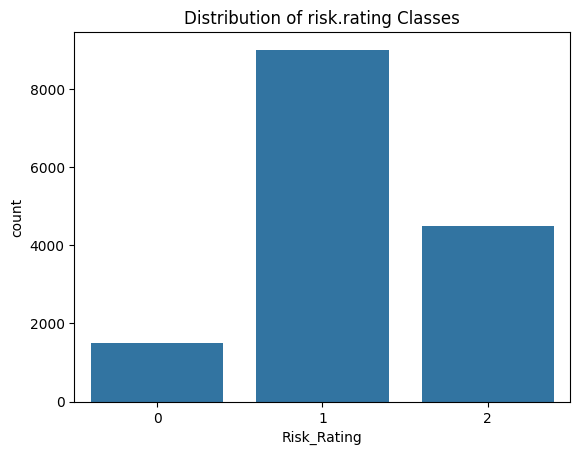

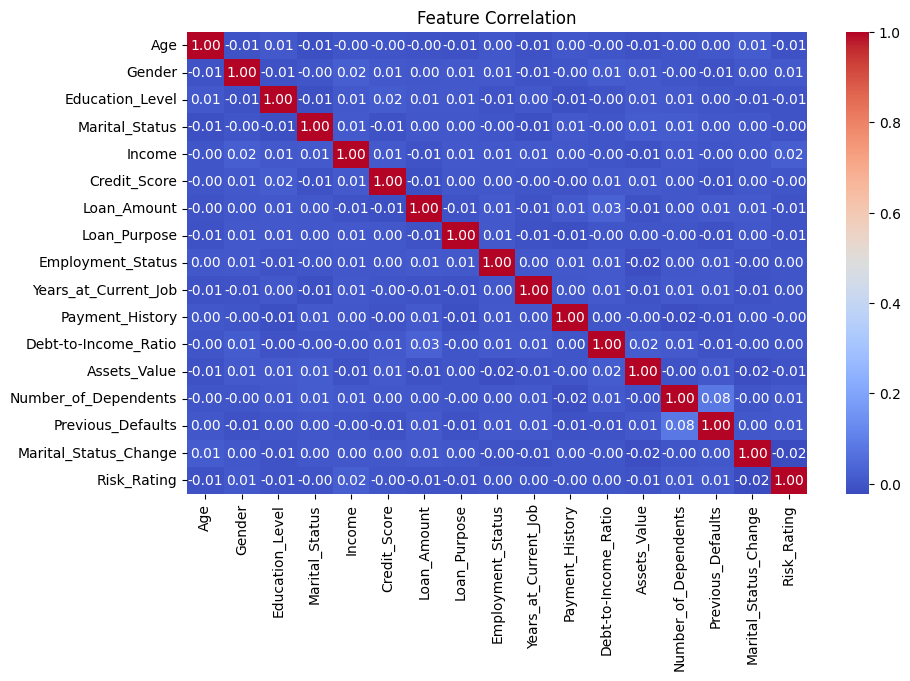

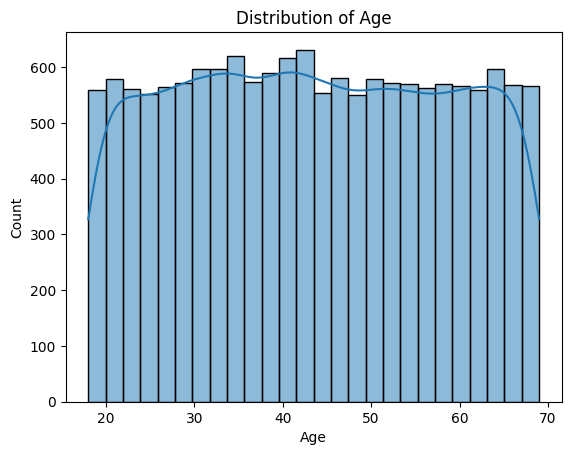

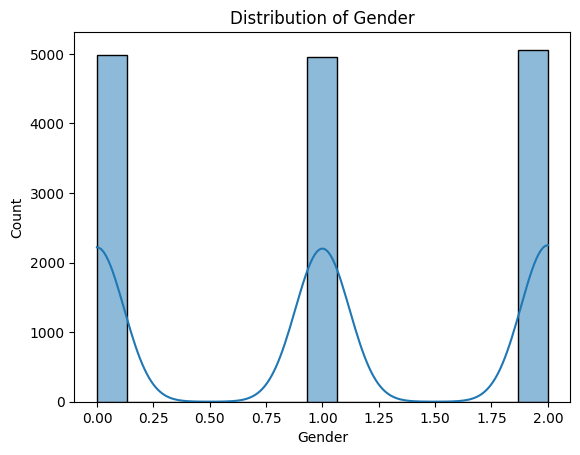

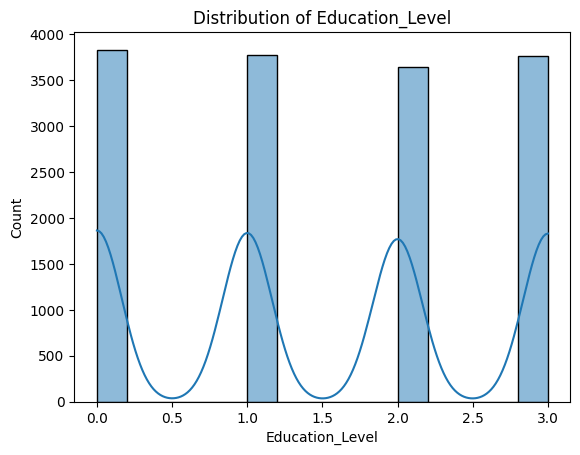

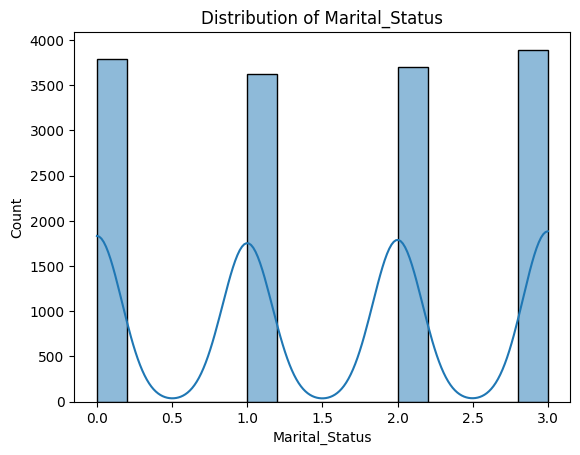

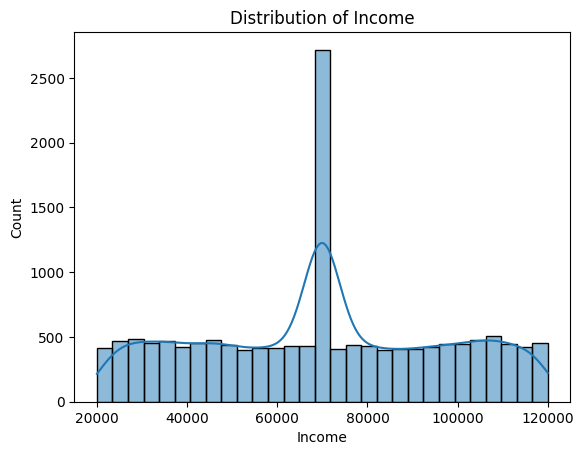

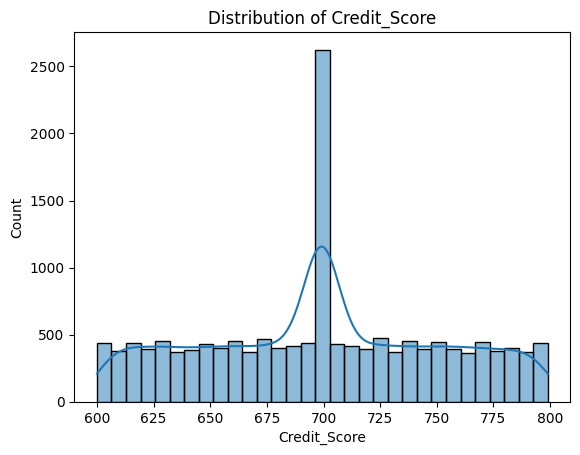

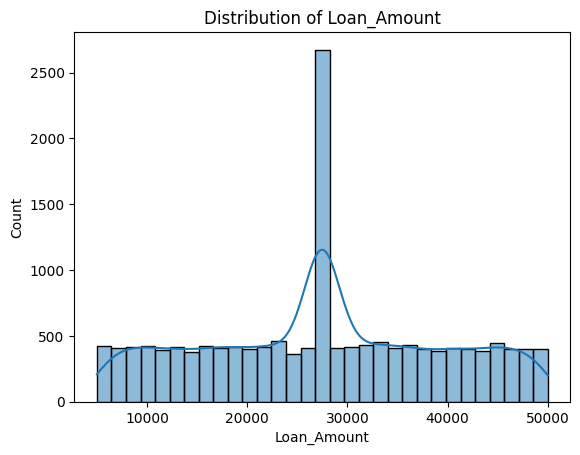

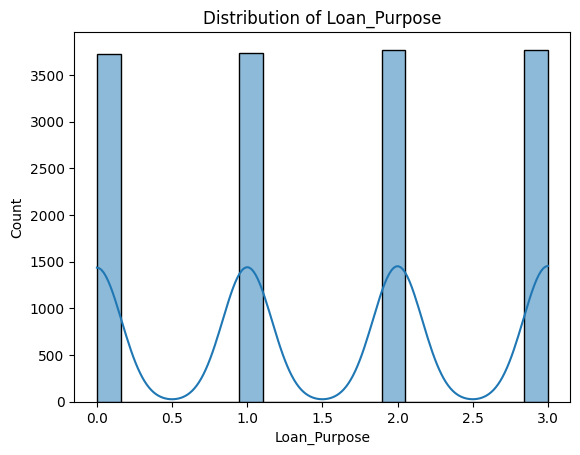

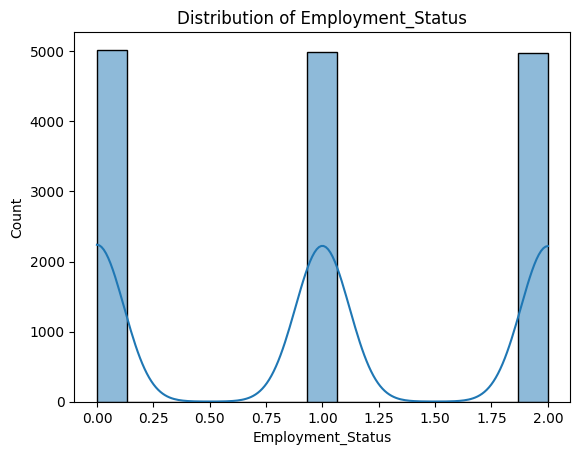

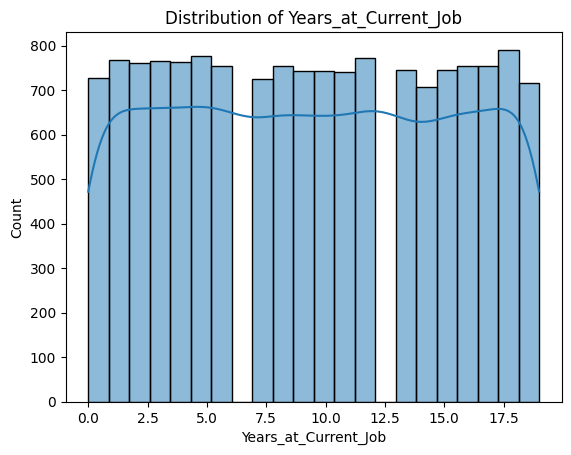

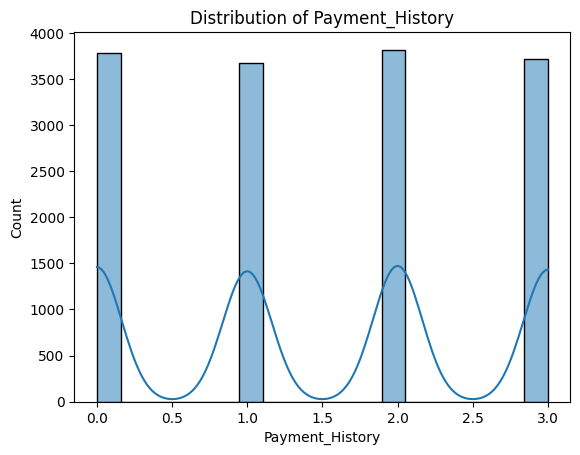

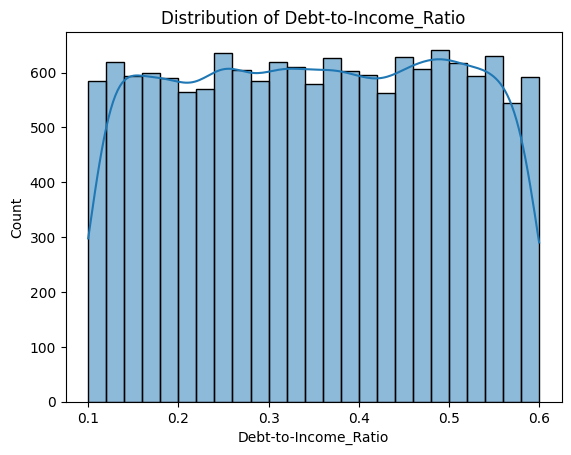

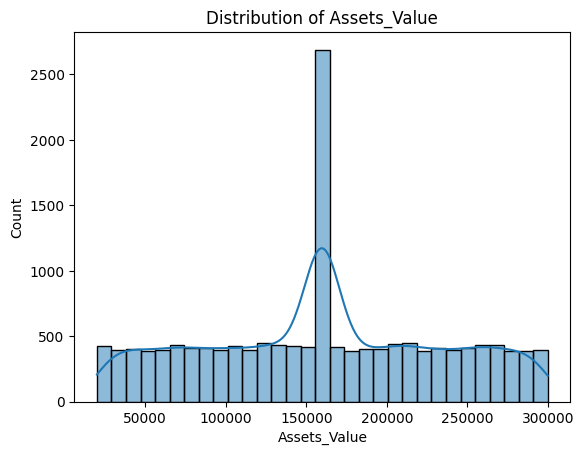

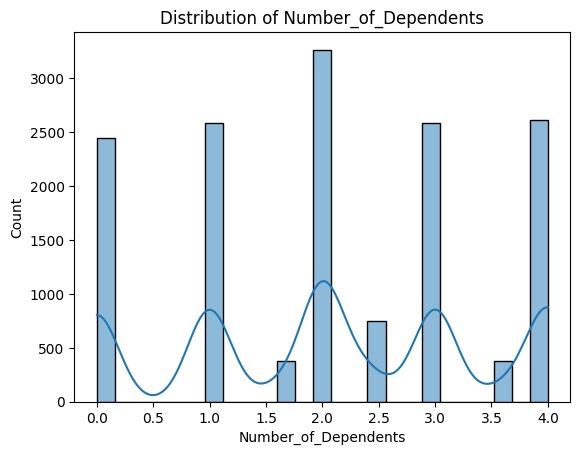

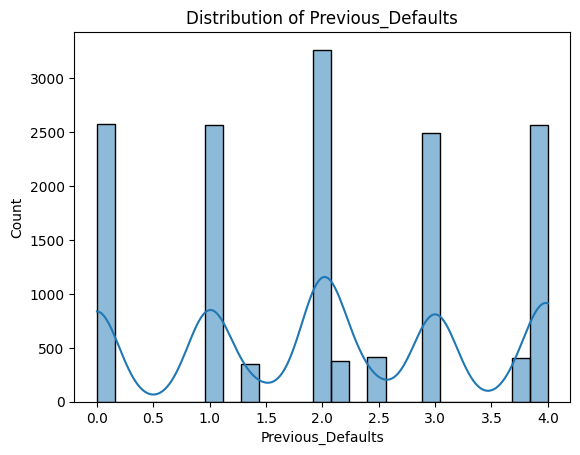

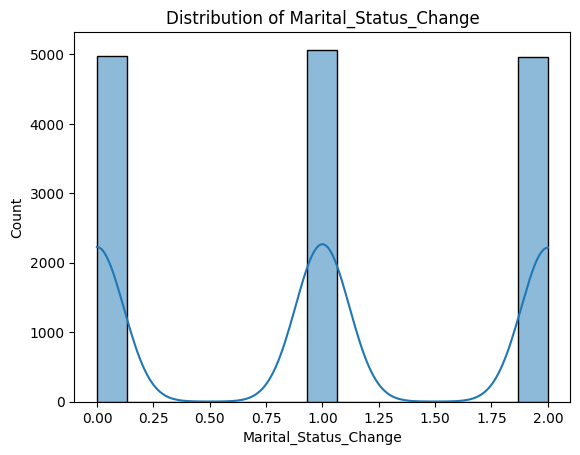

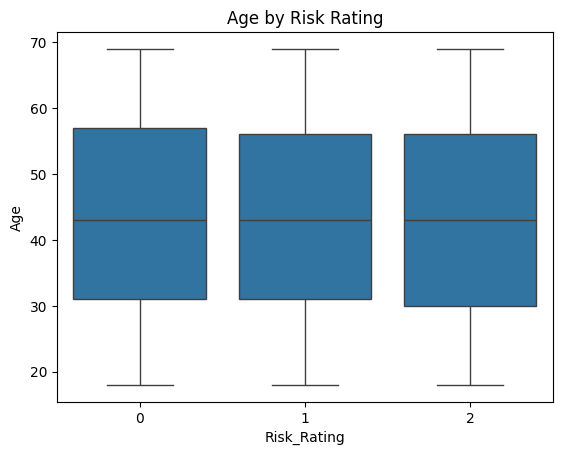

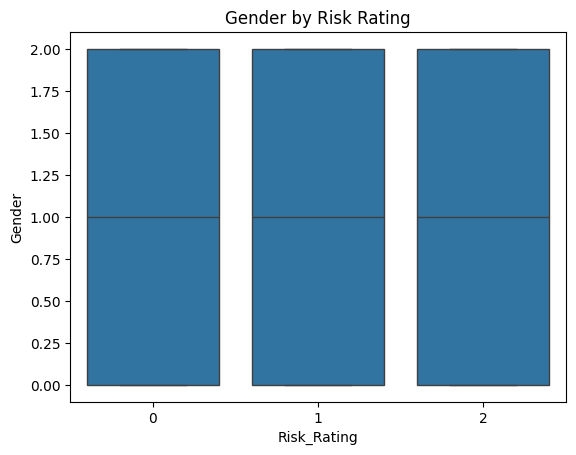

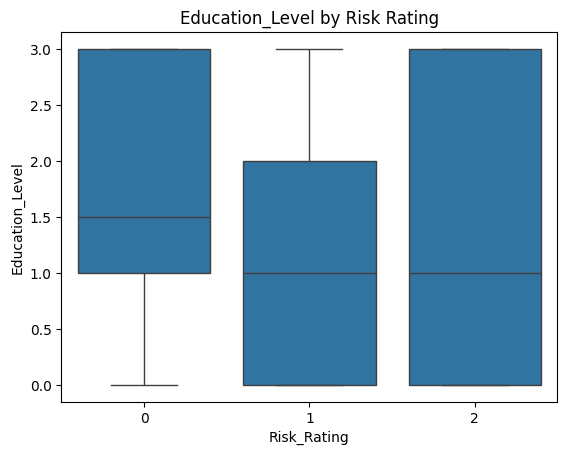

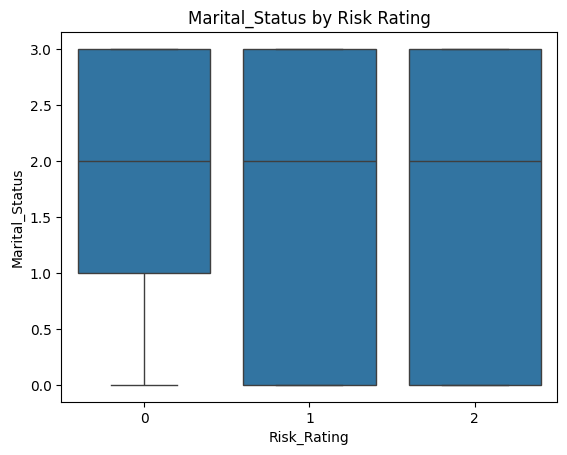

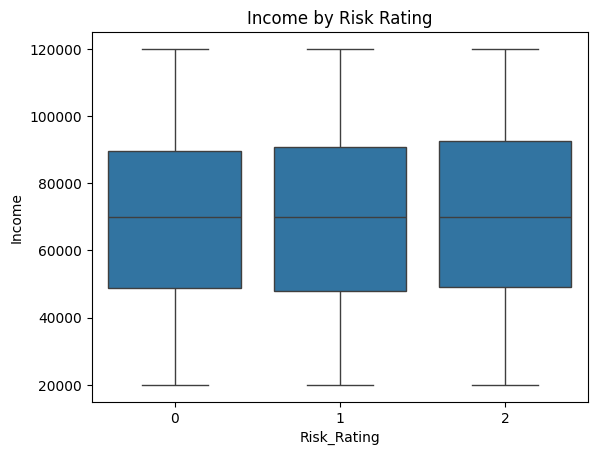

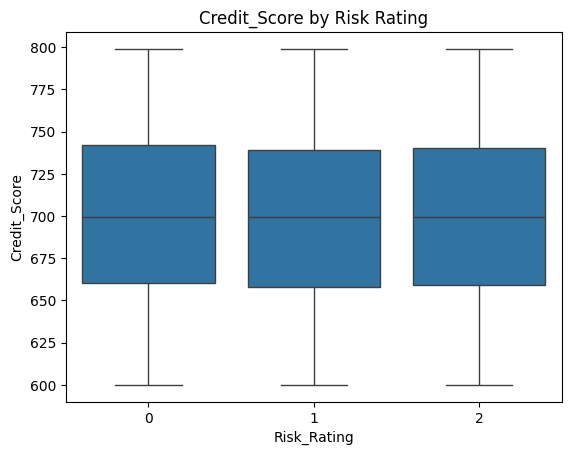

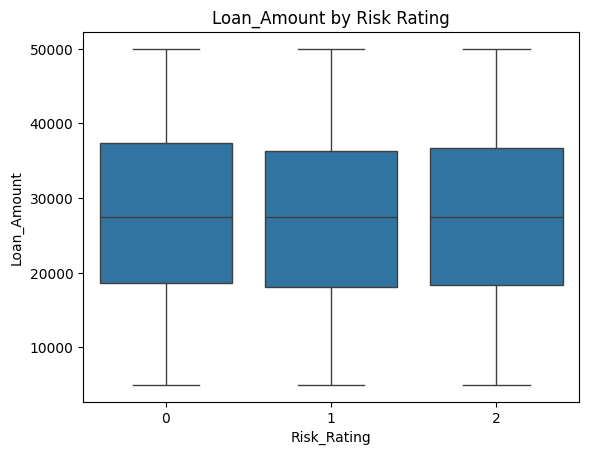

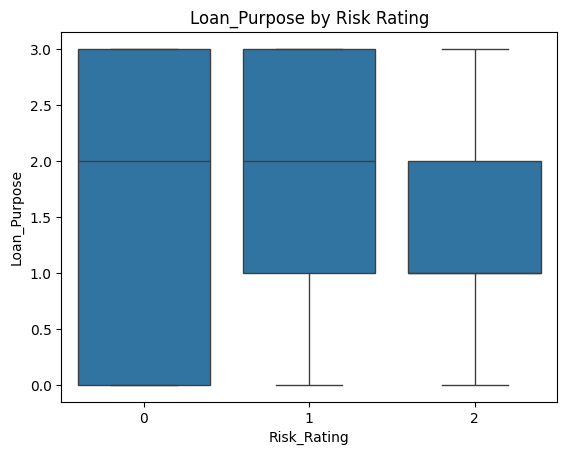

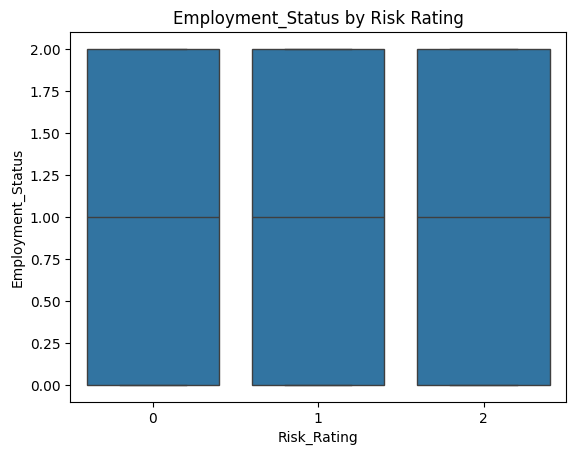

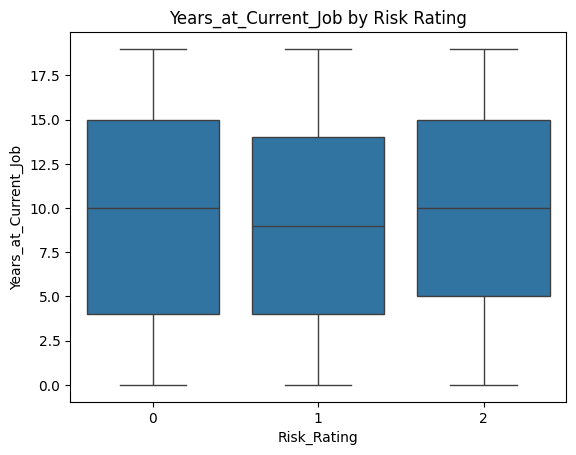

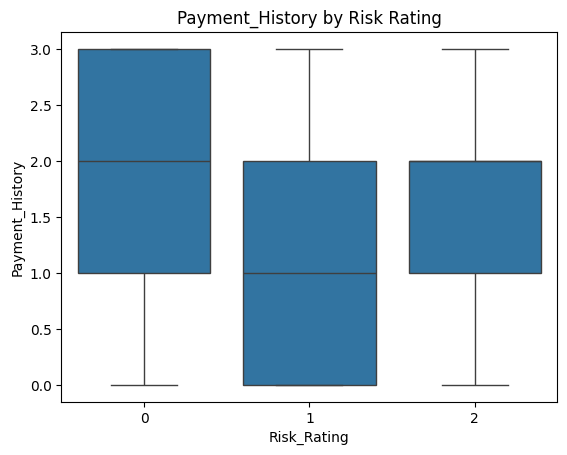

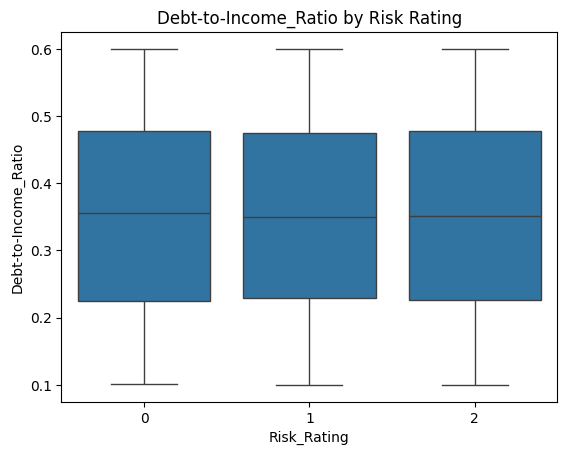

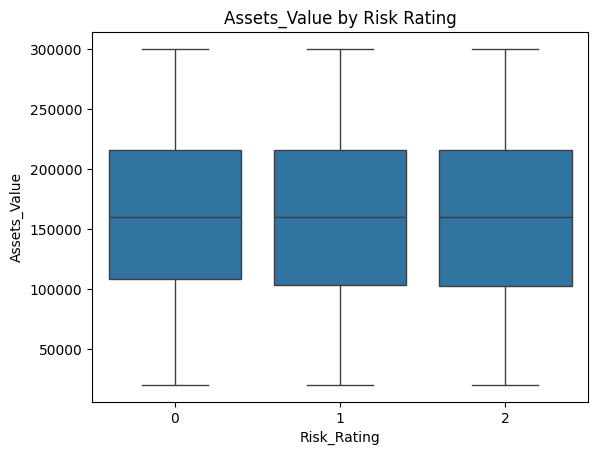

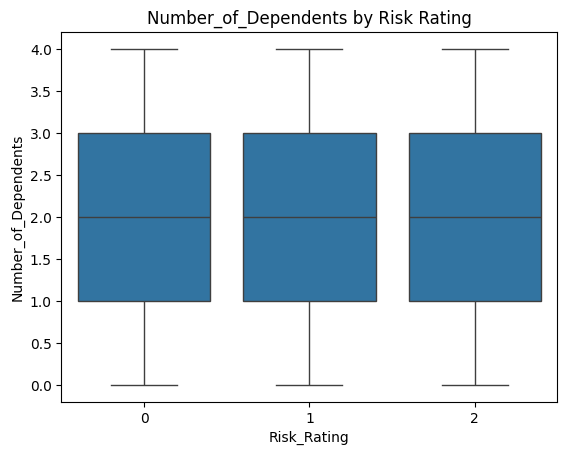

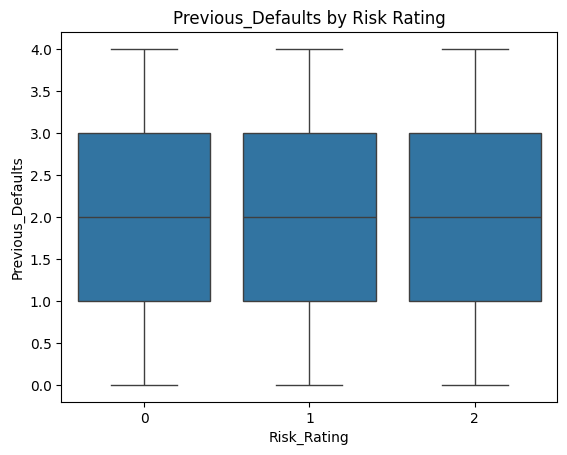

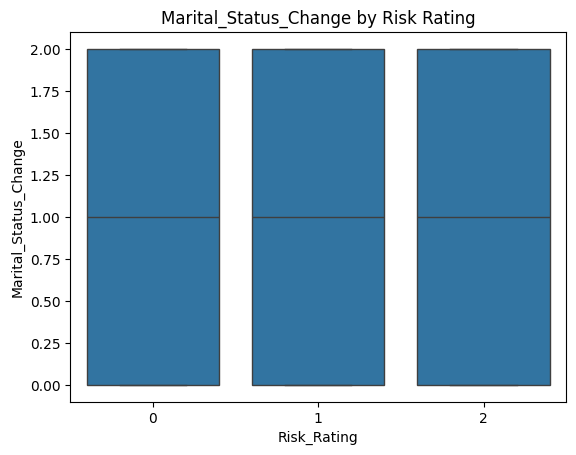

In [ ]:
# Class balance
sns.countplot(x="Risk_Rating", data=df_clean)
plt.title("Distribution of risk.rating Classes")
plt.show()

# Numeric correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation")
plt.show()

# Distribution plots for all features
for col in df_clean.select_dtypes(include=np.number).columns:
    if col != 'Risk_Rating':
        plt.figure()
        sns.histplot(df_clean[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()

# Boxplots for outliers by class
for col in df_clean.select_dtypes(include=np.number).columns:
    if col != 'Risk_Rating':
        plt.figure()
        sns.boxplot(x="Risk_Rating", y=col, data=df_clean)
        plt.title(f"{col} by Risk Rating")
        plt.show()

Complete Code: Ray + LightGBM for Multiclass Classification

In [ ]:
df_clean["Risk_Rating"].value_counts(normalize=True)




,proportion
Risk_Rating,
1,0.6
2,0.3
0,0.1


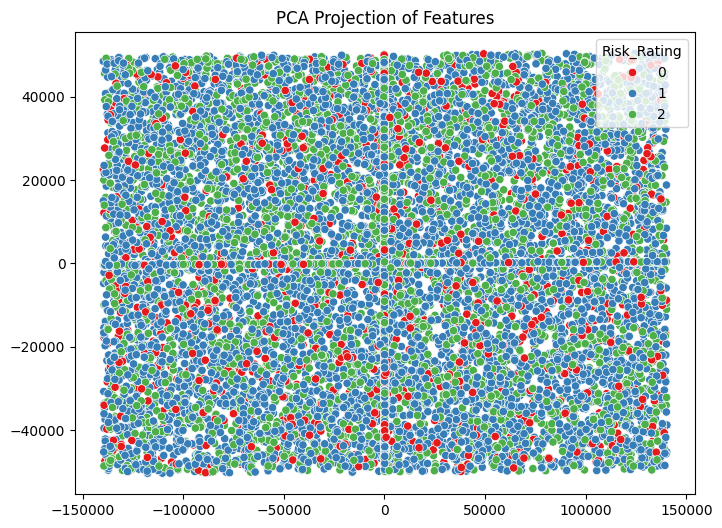

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

X = df_clean.drop("Risk_Rating", axis=1)
y = df_clean["Risk_Rating"]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set1")
plt.title("PCA Projection of Features")
plt.show()


In [ ]:
!pip install -q imbalanced-learn

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score, accuracy_score, confusion_matrix, cohen_kappa_score,
    roc_auc_score, roc_curve, auc
)
from imblearn.over_sampling import SMOTE

from ray import tune
from ray.tune.schedulers import ASHAScheduler

# data loader
def load_data():
    df = pd.read_csv("/content/risk_data_cleaned.csv")

    for col in df.select_dtypes(include='object').columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    X = df.drop(columns=["Risk Rating"])
    y = df["Risk Rating"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )


    return X_train, X_test, y_train, y_test

# evaluator
def evaluate_model(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    err_rate = 1 - acc
    f1 = f1_score(y_true, y_pred, average="weighted")
    kappa = cohen_kappa_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    cm_df = pd.DataFrame(cm, index=["True H", "True L", "True M"],
                            columns=["Pred H", "Pred L", "Pred M"])
    print("\nConfusion Matrix:")
    print(cm_df)

    print("\nSensitivity (TPR) and Specificity (TNR):")
    for i in range(3):
        TP = cm[i,i]
        FN = cm[i,:].sum() - TP
        FP = cm[:,i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        tpr = TP / (TP + FN) if (TP + FN) != 0 else 0
        tnr = TN / (TN + FP) if (TN + FP) != 0 else 0
        print(f"Class {i} -> TPR: {tpr:.4f}, TNR: {tnr:.4f}")

    try:
        y_bin = label_binarize(y_true, classes=[0,1,2])
        auc_score = roc_auc_score(y_bin, y_proba, average="macro", multi_class="ovr")
        print(f"\nROC AUC Score (macro): {auc_score:.4f}")
    except:
        print("ROC AUC couldn't be computed.")

    print(f"\n✅ Accuracy: {acc:.4f}\n❌ Error Rate: {err_rate:.4f}\n📊 F1 (weighted): {f1:.4f}\n📐 Kappa: {kappa:.4f}")

    tune.report(
        {
            "mean_accuracy": acc,
            "error_rate": err_rate,
            "f1": f1,
            "kappa": kappa,
            "done": True,
        }
    )

# training function
def train_svm_model(config):
    X_train, X_test, y_train, y_test = load_data()

    model = SVC(
        kernel=config["kernel"],
        C=config["C"],
        gamma=config["gamma"],
        probability=True
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    evaluate_model(y_test, y_pred, y_proba)

# search space
config = {
    "kernel": tune.grid_search(["rbf"]),
    "C": tune.loguniform(1e-2, 10),
    "gamma": tune.loguniform(1e-4, 1)
}

# tuner
tuner = tune.Tuner(
    train_svm_model,
    tune_config=tune.TuneConfig(
        metric="mean_accuracy",
        mode="max",
        scheduler=ASHAScheduler(),
        num_samples=4,
    ),
    param_space=config,
)

results = tuner.fit()


2025-04-25 00:58:39,529	INFO worker.py:1852 -- Started a local Ray instance.
2025-04-25 00:58:43,253	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+------------------------------------------------------------------------+
| Configuration for experiment     train_svm_model_2025-04-25_00-58-30   |
+------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                 |
| Scheduler                        AsyncHyperBandScheduler               |
| Number of trials                 4                                     |
+------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_svm_model_2025-04-25_00-58-30
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-04-25_00-58-30_909269_1093/artifacts/2025-04-25_00-58-43/train_svm_model_2025-04-25_00-58-30/driver_artifacts`

Trial status: 4 PENDING
Current time: 2025-04-25 00:58:51. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------

2025-04-25 01:20:49,949	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_svm_model_2025-04-25_00-58-30' in 0.0073s.


(train_svm_model pid=6469) 
(train_svm_model pid=6469) 
(train_svm_model pid=6469) 
(train_svm_model pid=6469) 
(train_svm_model pid=6469) Confusion Matrix:
(train_svm_model pid=6469)         Pred H  Pred L  Pred M
(train_svm_model pid=6469) True H       0     450       0
(train_svm_model pid=6469) True L       0    2700       0
(train_svm_model pid=6469) True M       0    1350       0
(train_svm_model pid=6469) Sensitivity (TPR) and Specificity (TNR):
(train_svm_model pid=6469) Class 2 -> TPR: 0.0000, TNR: 1.0000 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_svm_model pid=6469) ROC AUC Score (macro): 0.5011
(train_svm_model pid=6469) ✅ Accuracy: 0.6000
(train_svm_model pid=6469) ❌ Error Rate: 0.4000
(train_svm_model pid=6469) 📊 F1 (weighted): 0.4500
(train_svm_model pid=6469) 📐 Kappa: 

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_svm_roc(model, X_test, y_test, n_classes=3):
    y_score = model.predict_proba(X_test)
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("Multiclass ROC Curve - SVM")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()




✅ Best F1: 0.45
📊 Accuracy: 0.6
❌ Error Rate: 0.4
📐 Kappa: 0.0
⚙️ Params: {'kernel': 'rbf', 'C': 0.29558801801774715, 'gamma': 0.15846496663408946}
Training set size after SMOTE: (18900, 16)
Testing set size: (4500, 16)
Label distribution after SMOTE:
 Risk Rating
1    6300
2    6300
0    6300
Name: count, dtype: int64


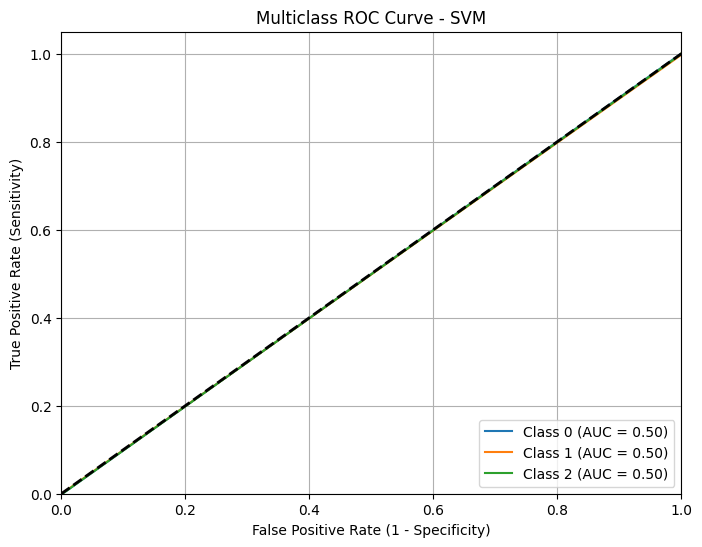

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
# Assume you're retrieving the best result after tuning:

best_result = results.get_best_result()
print("Best F1:", best_result.metrics["f1"])
print("Accuracy:", best_result.metrics["mean_accuracy"])
print("Error Rate:", best_result.metrics["error_rate"])
print("Kappa:", best_result.metrics["kappa"])
print("Params:", best_result.config)

# Retrain the model with the best configuration
X_train, X_test, y_train, y_test = load_data()
best_config = best_result.config

svm_best = SVC(
    C=best_config["C"],
    gamma=best_config["gamma"],
    kernel=best_config["kernel"],
    probability=True,  # مهم برای ROC
    random_state=42
)
svm_best.fit(X_train, y_train)

# plot the ROC curve:
plot_svm_roc(svm_best, X_test, y_test)

In [ ]:
df = pd.read_csv("/content/risk_data_cleaned.csv")
# Encode categorical features
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

X = df.drop(columns=["Risk Rating"])
y = df["Risk Rating"]
# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.3, random_state=42, stratify=y
)

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Training set size after SMOTE: {X_train_resampled.shape}")
print(f"Testing set size: {X_test.shape}")
print("Label distribution after SMOTE:\n", pd.Series(y_train_resampled).value_counts())


Training set size after SMOTE: (18900, 16)
Testing set size: (4500, 16)
Label distribution after SMOTE:
 Risk Rating
1    6300
2    6300
0    6300
Name: count, dtype: int64


In [ ]:





# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score, accuracy_score, confusion_matrix, cohen_kappa_score,
    roc_auc_score, roc_curve, auc
)
from imblearn.over_sampling import SMOTE

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from sklearn.preprocessing import MinMaxScaler


# data loader
def load_data():
    df = pd.read_csv("/content/risk_data_cleaned.csv")

    for col in df.select_dtypes(include='object').columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    X = df.drop(columns=["Risk Rating"])
    y = df["Risk Rating"]

    # Apply SMOTE before Train/Test split
    smote = SMOTE(random_state=42, k_neighbors=3)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Apply MinMax scaling after SMOTE
    # This is very important for SVM with RBF kernel, as SVM is sensitive to feature scales.
    # Also improves speed.
    scaler = MinMaxScaler()
    X_resampled_scaled = scaler.fit_transform(X_resampled)

    #  Then split the resampled data
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled_scaled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
    )

    # Show label distribution
    print("Label distribution after SMOTE (overall):\n", pd.Series(y_resampled).value_counts())
    print("Training set size:", X_train.shape)
    print("Testing set size:", X_test.shape)
    print("Training label distribution:\n", pd.Series(y_train).value_counts())
    print("Testing label distribution:\n", pd.Series(y_test).value_counts())

    return X_train, X_test, y_train, y_test

# evaluator
def evaluate_model(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    err_rate = 1 - acc
    f1 = f1_score(y_true, y_pred, average="weighted")
    kappa = cohen_kappa_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    cm_df = pd.DataFrame(cm, index=["True H", "True L", "True M"],
                            columns=["Pred H", "Pred L", "Pred M"])
    print("\nConfusion Matrix:")
    print(cm_df)

    print("\nSensitivity (TPR) and Specificity (TNR):")
    for i in range(3):
        TP = cm[i,i]
        FN = cm[i,:].sum() - TP
        FP = cm[:,i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        tpr = TP / (TP + FN) if (TP + FN) != 0 else 0
        tnr = TN / (TN + FP) if (TN + FP) != 0 else 0
        print(f"Class {i} -> TPR: {tpr:.4f}, TNR: {tnr:.4f}")

    try:
        y_bin = label_binarize(y_true, classes=[0,1,2])
        auc_score = roc_auc_score(y_bin, y_proba, average="macro", multi_class="ovr")
        print(f"\nROC AUC Score (macro): {auc_score:.4f}")
    except:
        print("ROC AUC couldn't be computed.")

    print(f"\n Accuracy: {acc:.4f}\n Error Rate: {err_rate:.4f}\n F1 (weighted): {f1:.4f}\n Kappa: {kappa:.4f}")

    tune.report(
        {
            "mean_accuracy": acc,
            "error_rate": err_rate,
            "f1": f1,
            "kappa": kappa,
            "done": True,
        }
    )

# training function
def train_svm_model(config):
    X_train, X_test, y_train, y_test = load_data()

    model = SVC(
        kernel=config["kernel"],
        C=config["C"],
        gamma=config["gamma"],
        probability=True
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    evaluate_model(y_test, y_pred, y_proba)

# search space
config = {
    "kernel": tune.grid_search(["rbf"]),
    "C": tune.loguniform(1e-2, 10),
    "gamma": tune.loguniform(1e-4, 1)
}

# tuner
tuner = tune.Tuner(
    train_svm_model,
    tune_config=tune.TuneConfig(
        metric="mean_accuracy",
        mode="max",
        scheduler=ASHAScheduler(),
        num_samples=4,
    ),
    param_space=config,
)

results = tuner.fit()


+------------------------------------------------------------------------+
| Configuration for experiment     train_svm_model_2025-04-25_02-11-23   |
+------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                 |
| Scheduler                        AsyncHyperBandScheduler               |
| Number of trials                 4                                     |
+------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_svm_model_2025-04-25_02-11-23
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-04-25_00-58-30_909269_1093/artifacts/2025-04-25_02-11-23/train_svm_model_2025-04-25_02-11-23/driver_artifacts`

Trial status: 4 PENDING
Current time: 2025-04-25 02:11:24. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------

2025-04-25 02:25:09,466	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_svm_model_2025-04-25_02-11-23' in 0.0066s.



Trial train_svm_model_9648a_00003 completed after 1 iterations at 2025-04-25 02:25:09. Total running time: 13min 45s
+------------------------------------------------------+
| Trial train_svm_model_9648a_00003 result             |
+------------------------------------------------------+
| checkpoint_dir_name                                  |
| time_this_iter_s                             433.516 |
| time_total_s                                 433.516 |
| training_iteration                                 1 |
| error_rate                                   0.41062 |
| f1                                           0.57938 |
| kappa                                        0.38407 |
| mean_accuracy                                0.58938 |
+------------------------------------------------------+

Trial status: 4 TERMINATED
Current time: 2025-04-25 02:25:09. Total running time: 13min 45s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Current best trial: 9648a_00003 with mean_accuracy=0.5893827

✅ Best F1: 0.579383924977335
📊 Accuracy: 0.5893827160493827
❌ Error Rate: 0.41061728395061725
📐 Kappa: 0.3840740740740741
⚙️ Params: {'kernel': 'rbf', 'C': 4.399440524912012, 'gamma': 0.5858845478032226}
Label distribution after SMOTE (overall):
 Risk Rating
1    9000
2    9000
0    9000
Name: count, dtype: int64
Training set size: (18900, 16)
Testing set size: (8100, 16)
Training label distribution:
 Risk Rating
2    6300
0    6300
1    6300
Name: count, dtype: int64
Testing label distribution:
 Risk Rating
0    2700
1    2700
2    2700
Name: count, dtype: int64


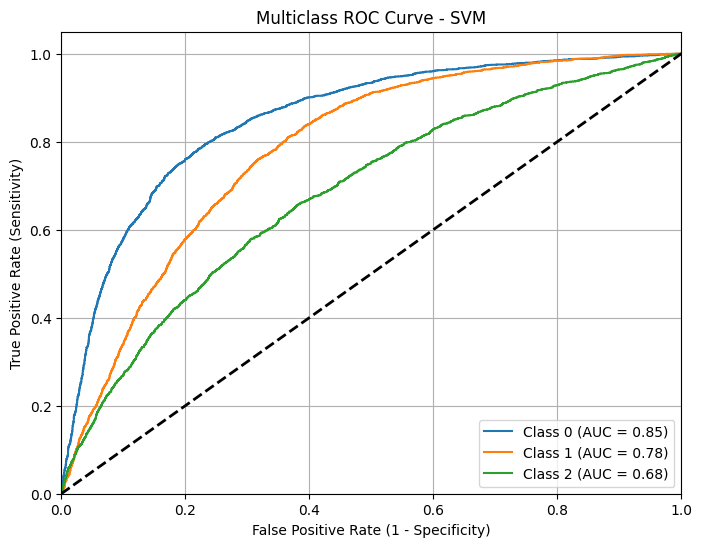

In [ ]:
best_result = results.get_best_result()
print(" Best F1:", best_result.metrics["f1"])
print(" Accuracy:", best_result.metrics["mean_accuracy"])
print(" Error Rate:", best_result.metrics["error_rate"])
print(" Kappa:", best_result.metrics["kappa"])
print(" Params:", best_result.config)

X_train, X_test, y_train, y_test = load_data()
best_config = best_result.config

svm_best = SVC(
    C=best_config["C"],
    gamma=best_config["gamma"],
    kernel=best_config["kernel"],
    probability=True,
    random_state=42
)
svm_best.fit(X_train, y_train)


plot_svm_roc(svm_best, X_test, y_test)